In [1]:
import numpy as np
import os
import random
import torch
import torch.nn as nn
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error

In [2]:
# Зафиксируем seed для воспроизводимости

def seed_everything(seed):
    random.seed(seed) # фиксируем генератор случайных чисел
    os.environ['PYTHONHASHSEED'] = str(seed) # фиксируем заполнения хешей
    np.random.seed(seed) # фиксируем генератор случайных чисел numpy
    torch.manual_seed(seed) # фиксируем генератор случайных чисел pytorch
    torch.cuda.manual_seed(seed) # фиксируем генератор случайных чисел для GPU
    torch.backends.cudnn.deterministic = True # выбираем только детерминированные алгоритмы (для сверток)
    torch.backends.cudnn.benchmark = False # фиксируем алгоритм вычисления сверток

In [3]:
seed_everything(42)

In [4]:
x1=np.random.uniform(-10,10,20000)
x2=np.random.uniform(-10,10,20000)

In [5]:
x1

array([-2.50919762,  9.01428613,  4.63987884, ..., -3.92603062,
       -1.13359987, -6.55470371])

In [6]:
x2

array([ 4.59996622, -6.30976009, -3.06720611, ..., -4.60861136,
       -1.31360456, -0.25152603])

In [7]:
def f(x1,x2):
    return np.sin(x1 + 2*x2)*np.exp(-(2*x1 + x2)**2)
    pass

In [8]:
y=f(x1,x2)
y

array([ 3.32700238e-01,  1.02001319e-60, -1.72502036e-17, ...,
       -2.01619926e-68,  1.56722809e-06, -2.07419899e-78])

In [9]:
df = pd.DataFrame([x1,x2,y]).T
df.columns=['x1', 'x2' , 'y']
df.head()

,x1,x2,y
0,-2.509198,4.599966,3.327002e-01
1,9.014286,-6.309760,1.020013e-60
2,4.639879,-3.067206,-1.725020e-17
3,1.973170,3.265613,2.052049e-23
4,-6.879627,-0.358213,-2.686867e-87


In [10]:
df.iloc[0, :].shape

(3,)

In [11]:
from sklearn.model_selection import train_test_split

# Let's say we want to split the data in 70:15:15 for train:valid:test dataset
train_size=0.7

X = df.drop(columns = ['y']).copy()
y = df['y']

# In the first step we will split the data in training and remaining dataset
X_train, X_rem, y_train, y_rem = train_test_split(X,y, train_size=0.7)

# Now since we want the valid and test size to be equal (10% each of overall data). 
# we have to define valid_size=0.5 (that is 50% of remaining data)
test_size = 0.5
X_valid, X_test, y_valid, y_test = train_test_split(X_rem,y_rem, test_size=0.5)

print(X_train.shape), print(y_train.shape)
print(X_valid.shape), print(y_valid.shape)
print(X_test.shape), print(y_test.shape)

(14000, 2)
(14000,)
(3000, 2)
(3000,)
(3000, 2)
(3000,)


(None, None)

In [12]:
num_features = 2

In [13]:
train_dataset = np.zeros((X_train.shape[0], num_features + 1))
train_dataset[:, :num_features] = X_train
train_dataset[:, num_features] = y_train

test_dataset = np.zeros((X_test.shape[0], num_features + 1))
test_dataset[:, :num_features] = X_test
test_dataset[:, num_features] = y_test

valid_dataset = np.zeros((X_valid.shape[0], num_features + 1))
valid_dataset[:, :num_features] = X_valid
valid_dataset[:, num_features] = y_valid

train_dataset = torch.from_numpy(train_dataset)
test_dataset = torch.from_numpy(test_dataset)
valid_dataset = torch.from_numpy(valid_dataset)

In [14]:
batch_size = 128

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size)
valid_loader = torch.utils.data.DataLoader(valid_dataset, batch_size=batch_size)

In [15]:
for batch in train_loader:
    features = batch[:, :num_features]
    labels = batch[:, num_features]
    print(features.shape)
    print(labels.shape)
    break

torch.Size([128, 2])
torch.Size([128])


In [16]:
class Net(torch.nn.Module):
    def __init__(self, n_features, n_hidden_neurons):
        super(Net, self).__init__()
        
        self.fc1 = torch.nn.Linear(n_features, n_hidden_neurons)
        self.activ1 = torch.nn.ReLU()
        self.fc2 = torch.nn.Linear(n_hidden_neurons, n_hidden_neurons)
        self.activ2 = torch.nn.ReLU()
        self.fc3 = torch.nn.Linear(n_hidden_neurons, 1)
        
    def forward(self, x):
        x = self.fc1(x)
        x = self.activ1(x)
        x = self.fc2(x)
        x = self.activ2(x)
        x = self.fc3(x)
        return x

    def inference(self, x):
        x = self.forward(x)
        return x
    
net = Net(num_features, 10)

In [17]:
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(net.parameters(), lr=1.0e-3)

In [18]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

In [19]:
net = net.to(device)

In [22]:
from tqdm.auto import tqdm
epochs = 50
history = []

net.train(True)
for i in tqdm(range(epochs)):
    epoch_loss = []
    # Iterate over batches
    for batch in train_loader:
        optimizer.zero_grad() # Do not forget this!
        # Forward
        x = batch[:, :num_features].float().to(device)
        y = batch[:, num_features].float().to(device)
        pred_y = net(x)

        # Compute loss
        loss = criterion(pred_y, y.unsqueeze(1))
        epoch_loss.append(loss.item())

        # Backward: propagate gradients
        loss.backward()
        
        # Update
        optimizer.step()
    if i % 10 == 0:
      history.append(np.array(epoch_loss).mean())
    
    # Iterate over batches
    valid_preds = []
    valid_labels = []
    for batch in valid_loader:
        x = batch[:, :num_features].float().to(device)
        y = batch[:, num_features].float()
      
        valid_labels += list(y)
        valid_preds += list(net.inference(x).cpu().detach().numpy())
    mse = mean_squared_error(valid_labels, valid_preds)
    print("valid MSE:", mse)

  0%|          | 0/50 [00:00<?, ?it/s]

valid MSE: 0.016368631
valid MSE: 0.016295036
valid MSE: 0.016250793
valid MSE: 0.016219357
valid MSE: 0.016184634
valid MSE: 0.01615815
valid MSE: 0.016137013
valid MSE: 0.016119977
valid MSE: 0.016094234
valid MSE: 0.016066091
valid MSE: 0.016038088
valid MSE: 0.016012818
valid MSE: 0.015975393
valid MSE: 0.015943525
valid MSE: 0.015902199
valid MSE: 0.015865156
valid MSE: 0.015822196
valid MSE: 0.015782032
valid MSE: 0.015719315
valid MSE: 0.015655672
valid MSE: 0.015589198
valid MSE: 0.015520426
valid MSE: 0.015464521
valid MSE: 0.015377757
valid MSE: 0.015292183
valid MSE: 0.015229169
valid MSE: 0.015156136
valid MSE: 0.0150735015
valid MSE: 0.014997628
valid MSE: 0.014941873
valid MSE: 0.0148535585
valid MSE: 0.014777146
valid MSE: 0.014718115
valid MSE: 0.014622738
valid MSE: 0.014532401
valid MSE: 0.014461695
valid MSE: 0.014397972
valid MSE: 0.014338402
valid MSE: 0.014293794
valid MSE: 0.014226817
valid MSE: 0.014156464
valid MSE: 0.014101627
valid MSE: 0.014045305
valid MSE:

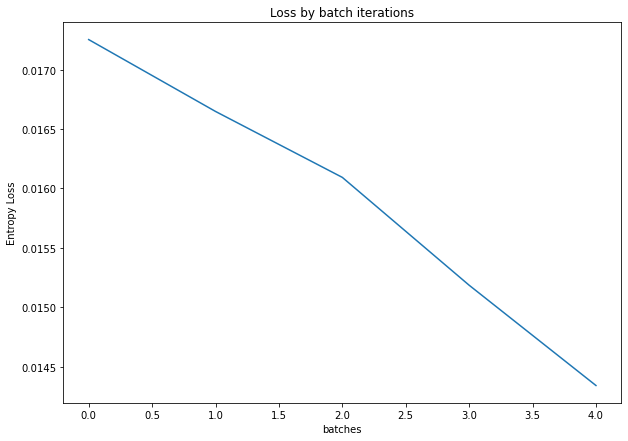

In [23]:
plt.figure(figsize=(10, 7))
plt.plot(history)

plt.title('Loss by batch iterations')
plt.ylabel('Entropy Loss')
plt.xlabel('batches')

plt.show()

In [24]:
# net.train(False)

test_preds = []
test_labels = []
for batch in test_loader:
    x = batch[:, :num_features].float().to(device)
    y = batch[:, num_features].float()
      
    test_labels += list(y)
    test_preds += list(net.inference(x).cpu().detach().numpy())

assert len(test_preds) == len(test_labels)

In [25]:
# Display metrics
mse = mean_squared_error(test_labels, test_preds)
print("test MSE:", mse)

test MSE: 0.015535453


In [26]:
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
import seaborn as sns

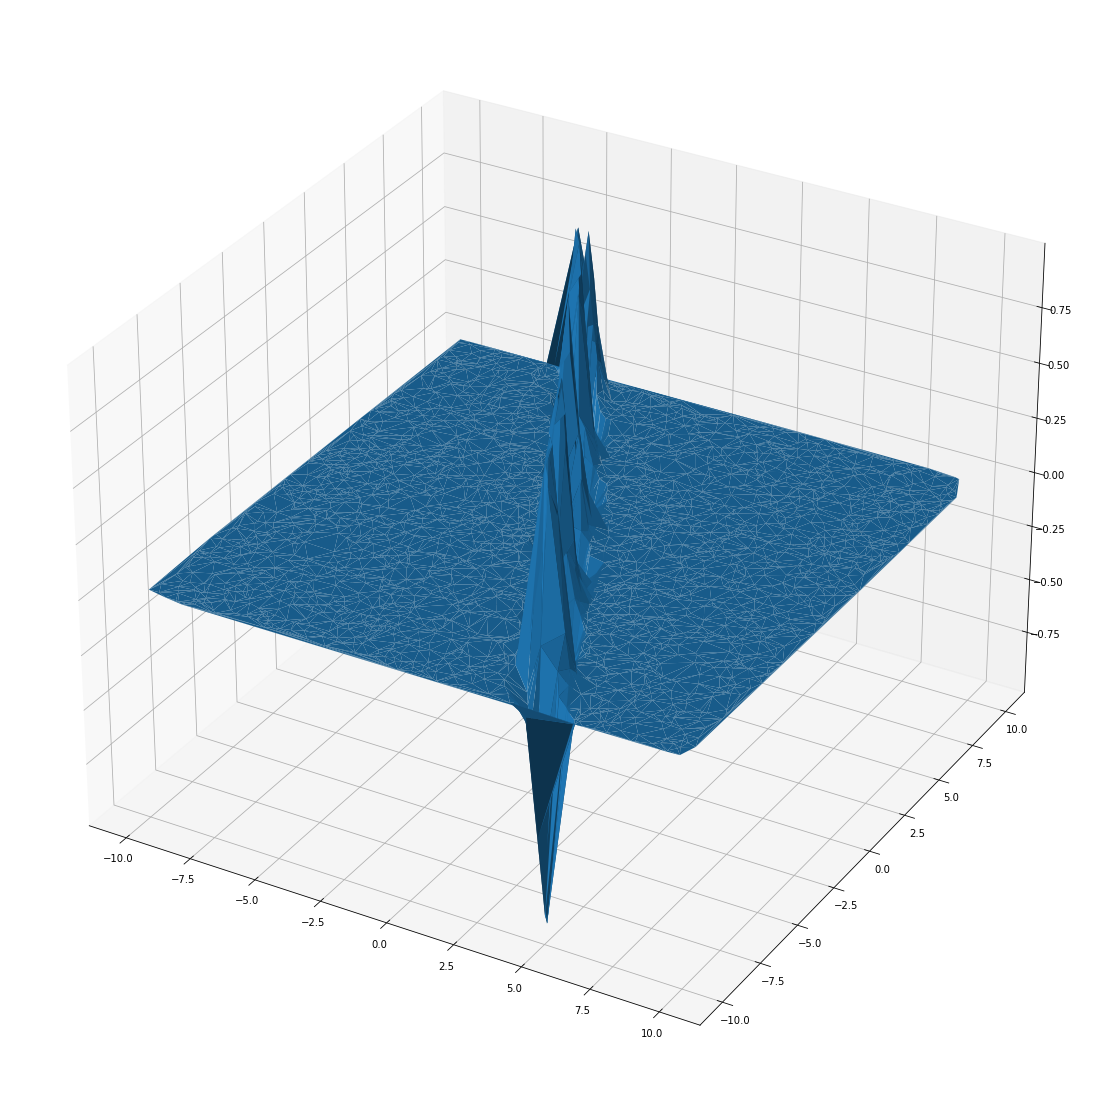

In [27]:
fig = plt.figure(figsize = (20, 20))
ax = fig.add_subplot(1, 1, 1, projection = '3d')
surf = ax.plot_trisurf(test_dataset[:, 0], test_dataset[:, 1], test_dataset[:, 2])

C:\Users\zhuko\AppData\Local\Temp/ipykernel_15016/2450998139.py:3: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\cb\pytorch_1000000000000\work\torch\csrc\utils\tensor_new.cpp:233.)
  surf = ax.plot_trisurf(test_dataset[:, 0], test_dataset[:, 1], torch.tensor(test_preds).squeeze(1))


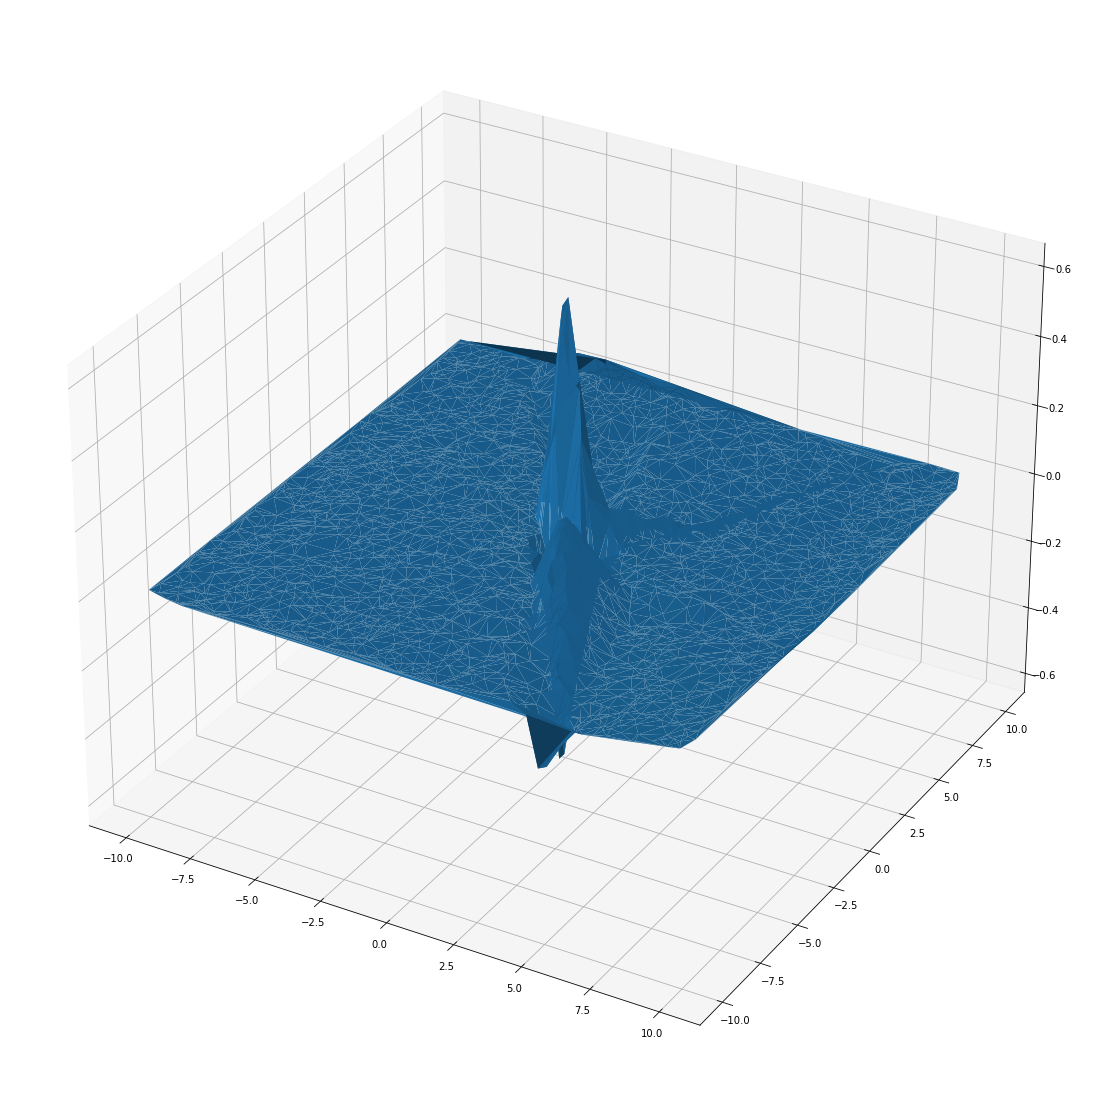

In [28]:
fig = plt.figure(figsize = (20, 20))
ax = fig.add_subplot(1, 1, 1, projection = '3d')
surf = ax.plot_trisurf(test_dataset[:, 0], test_dataset[:, 1], torch.tensor(test_preds).squeeze(1))